In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import emcee
import glob
import h5py
import multiprocessing as multi
import pandas as pd
import pystan
from scipy.interpolate import interp1d
from scipy.optimize import fmin_powell
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm_notebook
import warnings

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [15]:
class RunningChiEffPosterior(object):
    def __init__(self, chi_eff_samples, m1_samples, chi_eff_sel_samples, m1_sel_samples, sel_wts):
        self.chi_eff_samples = chi_eff_samples
        self.m1_samples = m1_samples
        self.chi_eff_sel_samples = chi_eff_sel_samples
        self.m1_sel_samples = m1_sel_samples
        self.log_sel_wts = log(sel_wts)
        
        self.m0 = 30
        
    def mu_sigma(self, m1, mu0, sigma0, alpha, beta):
        return mu0 + alpha*(m1/self.m0-1), sigma0*exp(beta*(m1/self.m0-1))
    
    def log_pdet(self, mu0, sigma0, alpha, beta):
        mus, sigmas = self.mu_sigma(self.m1_sel_samples, mu0, sigma0, alpha, beta)

        dist = ss.norm(loc=mus, scale=sigmas)
        logp_chieff = dist.logpdf(self.chi_eff_sel_samples) - log(dist.cdf(1) - dist.cdf(-1))
        
        return logp_chieff - self.log_sel_wts
    
    def neff_det(self, log_pdet):
        lpmax = np.max(log_pdet)
        
        return exp(logaddexp.reduce(log_pdet) - lpmax)
    
    def __call__(self, theta):
        mu0, sigma0, alpha, beta = theta
        
        if sigma0 < 0:
            return np.NINF
        
        # Check that -1 < mu < 1 for 1 < m < 100
        mlow = 1
        mhigh = 100
        mulow, sigmalow = self.mu_sigma(mlow, mu0, sigma0, alpha, beta)
        muhigh, sigmahigh = self.mu_sigma(mhigh, mu0, sigma0, alpha, beta)
        
        if mulow < -1 or mulow > 1:
            return np.NINF
        if muhigh < -1 or muhigh > 1:
            return np.NINF
        
        # Flat prior in mu0, sigma0, flat prior in alpha, beta
        lp = ss.lognorm(s=1,scale=0.1).logpdf(sigmalow) + ss.lognorm(s=1,scale=0.1).logpdf(sigmahigh)
        lp += log((mhigh-mlow)*sigma0/self.m0) + beta*((mhigh+mlow)/self.m0 - 2)
        
        N = len(self.chi_eff_samples)
        logpd = self.log_pdet(mu0, sigma0, alpha, beta)
        neff = self.neff_det(logpd)
        
        if neff < 5*N:
            warnings.warn('too few samples in selection integral')
            return np.NINF
        
        log_mu = logaddexp.reduce(logpd) - log(len(logpd))
        
        lsel = -N*log_mu + (3*N + N*N)/(2*neff)

        ll = 0.0
        for chieffs, m1s in zip(self.chi_eff_samples, self.m1_samples):
            m, s = self.mu_sigma(m1s, mu0, sigma0, alpha, beta)
            dist = ss.norm(loc=m, scale=s)
            
            logp = dist.logpdf(chieffs) - log(dist.cdf(1) - dist.cdf(-1))
            ll += logaddexp.reduce(logp) - log(len(logp))
            
            
        result = ll + lp + lsel
        
        if np.isnan(result):
            print(theta)
            print(ll, lp, lsel)
            
        return result

In [16]:
def simulate_chi_eff_prior(size=1):
    mas = np.random.uniform(size=size)
    mbs = np.random.uniform(size=size)
    m1s = where(mas > mbs, mas, mbs)
    m2s = where(mas > mbs, mbs, mas)
    
    ct1s = np.random.uniform(low=-1, high=1, size=size)
    ct2s = np.random.uniform(low=-1, high=1, size=size)
    
    a1s = np.random.uniform(size=size)
    a2s = np.random.uniform(size=size)
    
    return (m1s*ct1s*a1s + m2s*ct2s*a2s)/(m1s+m2s)

In [17]:
chi_effs_prior = simulate_chi_eff_prior(10000)
approx_chi_eff_li_prior = ss.gaussian_kde(chi_effs_prior)

In [18]:
mu0_true = 0.05
sigma0_true = 0.1
alpha_true = -0.1
beta_true = -0.5

In [87]:
with h5py.File('design-selected.h5', 'r') as f:
    chi_effs_sel = array(f['chi_effs'])
    m1s_sel = array(f['m1s'])

In [89]:
N = 100
dist = ss.norm(loc=mu0_true + (m1s_sel/30 - 1)*alpha_true, scale=sigma0_true*exp(beta_true*(m1s_sel/30-1)))
wts = dist.pdf(chi_effs_sel)/(dist.cdf(1)-dist.cdf(-1))
wts /= np.sum(wts)
c = np.random.choice(len(wts), size=N, replace=False, p=wts)
chi_eff_true = chi_effs_sel[c]
m1_true = m1s_sel[c]

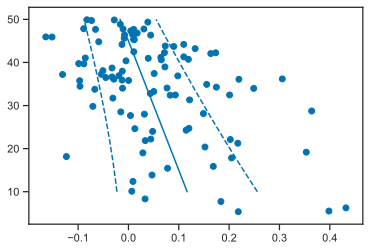

In [92]:
m = linspace(10, 50, 100)
mu_m = mu0_true + (m/30-1)*alpha_true
s_m = sigma0_true*exp(beta_true*(m/30-1))
plot(mu_m, m)
plot(mu_m+s_m,m,'--', color=sns.color_palette()[0])
plot(mu_m-s_m,m,'--', color=sns.color_palette()[0])
scatter(chi_eff_true, m1_true)

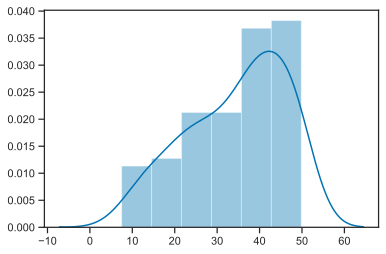

In [49]:
sns.distplot(m1_true)

In [50]:
chi_eff_obs = chi_eff_true + 0.1*randn(len(chi_eff_true))
m1_obs = m1_true + 5*randn(len(m1_true))

In [51]:
Ns = 100
chi_eff_samples = [ceo + 0.1*randn(Ns) for ceo in chi_eff_obs]
m1_samples = [m1 + 5*randn(Ns) for m1 in m1_obs]

In [52]:
try:
    pool.close()
except:
    pass
pool = multi.Pool()

p0 = array([mu0_true, sigma0_true, alpha_true, beta_true])

Nw = 16
pts = p0 + 1e-3*randn(Nw, 4)
logpost = RunningChiEffPosterior(chi_eff_samples, m1_samples, chi_effs_sel, m1s_sel, 0.5*ones_like(m1s_sel))
sampler = emcee.EnsembleSampler(Nw, 4, logpost, pool=pool)

/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: too few samples in selection integral
/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: too few samples in selection integral
/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: too few samples in selection integral


In [57]:
sampler.reset()

In [85]:
pts, lnprobs, rstate = sampler.run_mcmc(pts, 128, progress=True)

/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 128/128 [01:33<00:00,  1.36it/s]


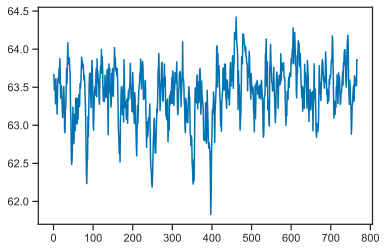

In [93]:
plot(mean(sampler.lnprobability, axis=0))

In [94]:
asampler = az.from_emcee(sampler, var_names=['mu0', 'sigma0', 'alpha', 'beta'])
az.ess(asampler)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu0      float64 161.4
    sigma0   float64 145.9
    alpha    float64 169.6
    beta     float64 233.3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1215796a0>,
      dtype=object)

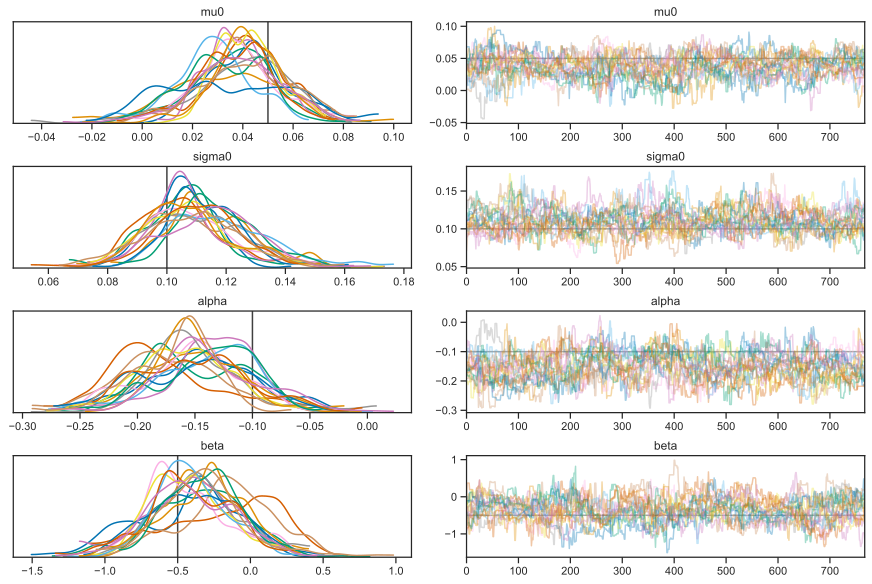

In [95]:
az.plot_trace(asampler, lines=[('mu0', {}, mu0_true), ('sigma0', {}, sigma0_true), ('alpha', {}, alpha_true), ('beta', {}, beta_true)])

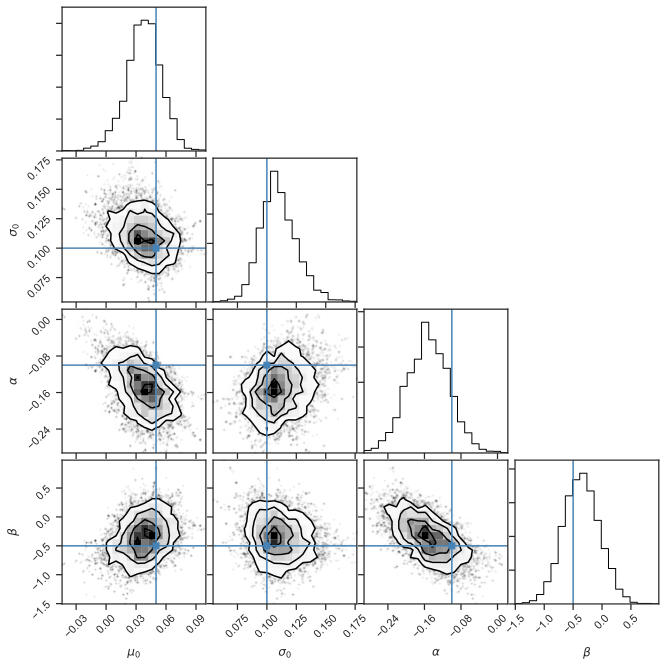

In [96]:
corner.corner(sampler.flatchain, truths=[mu0_true, sigma0_true, alpha_true, beta_true],
              labels=[r'$\mu_0$', r'$\sigma_0$', r'$\alpha$', r'$\beta$']);

In [97]:
az.to_netcdf(asampler, "pop-samples-running-future.nc")

'pop-samples-running-future.nc'

In [98]:
m1s = logspace(log10(5), log10(50), 100)
chis = linspace(-1, 1, 100)
M1S, CHIS = meshgrid(m1s, chis, indexing='ij')

In [100]:
Ndraw = 1000
PCHIS = zeros_like(CHIS)
for i in tqdm_notebook(range(Ndraw)):
    j = randint(asampler.posterior.chain[-1])
    k = randint(asampler.posterior.draw[-1])
    
    mu0 = asampler.posterior.mu0.values[j,k]
    sigma0 = asampler.posterior.sigma0.values[j,k]
    alpha = asampler.posterior.alpha.values[j,k]
    beta = asampler.posterior.beta.values[j,k]
    
    m, s = logpost.mu_sigma(M1S, mu0, sigma0, alpha, beta)
    dist = ss.norm(loc=m, scale=s)
    
    PCHIS += dist.pdf(CHIS)/(dist.cdf(1)-dist.cdf(-1))
PCHIS /= Ndraw

Text(0, 0.5, '$m_1$ ($M_\\odot$)')

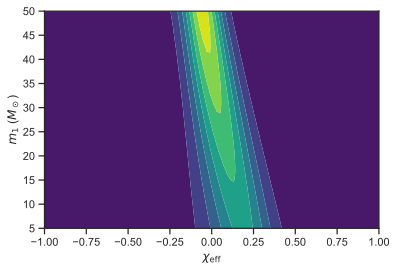

In [101]:
contourf(CHIS, M1S, PCHIS, cmap='viridis', vmin=0)
xlabel(r'$\chi_\mathrm{eff}$')
ylabel(r'$m_1$ ($M_\odot$)')

In [102]:
m, s = logpost.mu_sigma(M1S, mu0_true, sigma0_true, alpha_true, beta_true)
dist = ss.norm(loc=m, scale=s)
PCHIS_TRUE = dist.pdf(CHIS)/(dist.cdf(1)-dist.cdf(-1))

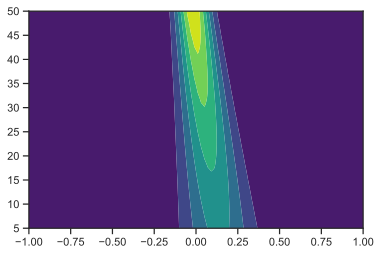

In [103]:
contourf(CHIS, M1S, PCHIS_TRUE, cmap='viridis', vmin=0)

## GWTC-1

What happens if we apply this to GWTC-1?

In [3]:
zs_interp = expm1(linspace(log(1), log(2+1), 1000))
ds_interp = Planck15.luminosity_distance(zs_interp).to(u.Mpc).value
z_of_d = interp1d(ds_interp, zs_interp)

posts = []
for fn in tqdm_notebook(glob.glob('GWTC-1/*.hdf5')):
    with h5py.File(fn, 'r') as f:
        ds = array(f['Overall_posterior']['luminosity_distance_Mpc'])
        z = z_of_d(ds)
        m1 = array(f['Overall_posterior']['m1_detector_frame_Msun'])/(1+z)
        m2 = array(f['Overall_posterior']['m2_detector_frame_Msun'])/(1+z)
        ct1 = array(f['Overall_posterior']['costilt1'])
        ct2 = array(f['Overall_posterior']['costilt2'])
        a1 = array(f['Overall_posterior']['spin1'])
        a2 = array(f['Overall_posterior']['spin2'])
        chi_eff = (m1*a1*ct1 + m2*a2*ct2)/(m1+m2)
        posts.append(pd.DataFrame({'m1': m1, 'm2': m2, 'z': z, 'chi_eff': chi_eff}))

In [4]:
def simulate_chi_eff_prior(size=1):
    mas = np.random.uniform(size=size)
    mbs = np.random.uniform(size=size)
    m1s = where(mas > mbs, mas, mbs)
    m2s = where(mas > mbs, mbs, mas)
    
    ct1s = np.random.uniform(low=-1, high=1, size=size)
    ct2s = np.random.uniform(low=-1, high=1, size=size)
    
    a1s = np.random.uniform(size=size)
    a2s = np.random.uniform(size=size)
    
    return (m1s*ct1s*a1s + m2s*ct2s*a2s)/(m1s+m2s)

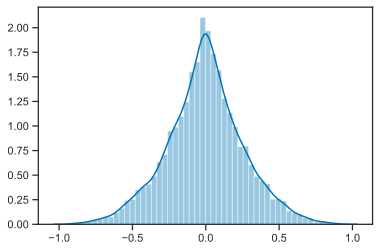

In [5]:
sns.distplot(simulate_chi_eff_prior(10000))

In [6]:
chi_effs_prior = simulate_chi_eff_prior(10000)
approx_chi_eff_li_prior = ss.gaussian_kde(chi_effs_prior)

In [7]:
def li_prior_wt(z, chieff):
    return (1+z)**2*Planck15.luminosity_distance(z).to(u.Mpc).value**2*(Planck15.comoving_distance(z).to(u.Mpc).value + (1+z)*Planck15.hubble_distance.to(u.Mpc).value / Planck15.efunc(z))*approx_chi_eff_li_prior(chieff)

In [8]:
for p in tqdm_notebook(posts):
    p['li_prior_wt'] = li_prior_wt(p['z'], p['chi_eff'])

In [9]:
MMin = 5
def pop_prior_wt(m1, m2, z):
    return 1.0/m1/(m1-MMin)*(1+z)**1.7*Planck15.differential_comoving_volume(z).to(u.Mpc**3/u.sr).value*4*pi

In [10]:
for p in posts:
    p['pop_prior_wt'] = pop_prior_wt(p['m1'], p['m2'], p['z'].values)

Neff = 211
Neff = 20660
Neff = 1763
Neff = 449
Neff = 3297
Neff = 14271
Neff = 655
Neff = 594
Neff = 2165
Neff = 448


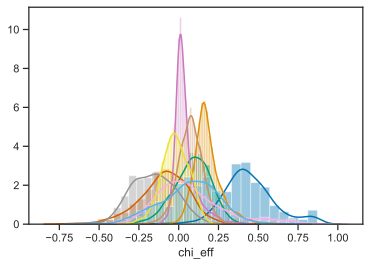

In [11]:
likelihoods = []
for p in posts:
    wts = p['pop_prior_wt']/p['li_prior_wt']
    rs = np.random.uniform(low=0, high=np.max(wts), size=len(wts))
    s = rs < wts
    sns.distplot(p['chi_eff'][s])
    likelihoods.append(p[s])
for l in likelihoods:
    print('Neff = {:d}'.format(len(l)))

In [22]:
with h5py.File('design-selected.h5', 'r') as f:
    chi_eff_sel = array(f['chi_effs'])
    m1_sel = array(f['m1s'])
    N_draw = f.attrs['N_draw']

In [14]:
sel_thin = 5
chiel = []
m1l = []
for l in likelihoods:
    c = np.random.choice(len(l), size=100, replace=False)
    lc = l.iloc[c]
    chiel.append(lc['chi_eff'].to_numpy())
    m1l.append(lc['m1'].to_numpy())

In [58]:
model = pystan.StanModel(file='chi_eff_running.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50742b98cc6c6a9d891c1724df41fd9e NOW.
/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp14t2rxc5/stanfit4anon_model_50742b98cc6c6a9d891c1724df41fd9e_271120248546940878.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [71]:
data = {
    'Nobs': len(chiel),
    'Nsamp': len(chiel[0]),
    'chi_eff': chiel,
    'm1': m1l,
    
    'Nsel': len(chi_eff_sel[::sel_thin]),
    'Ndraw': N_draw,
    'chi_eff_sel': chi_eff_sel[::sel_thin],
    'm1_sel': m1_sel[::sel_thin],
    'log_sel_wt': log(0.5)*ones_like(chi_eff_sel[::sel_thin]),
    
    'mlow': 5,
    'mhigh': 100,
    'sigma_min': 0.05
}

In [72]:
samples = model.sampling(data=data)
asamples = az.convert_to_inference_data(samples)

/Users/wfarr/anaconda3/envs/chieffregression/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [73]:
az.ess(asamples, var_names=['mu0', 'sigma0', 'alpha', 'beta'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu0      float64 3.369e+03
    sigma0   float64 2.513e+03
    alpha    float64 1.401e+03
    beta     float64 2.119e+03

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122794ef0>,
      dtype=object)

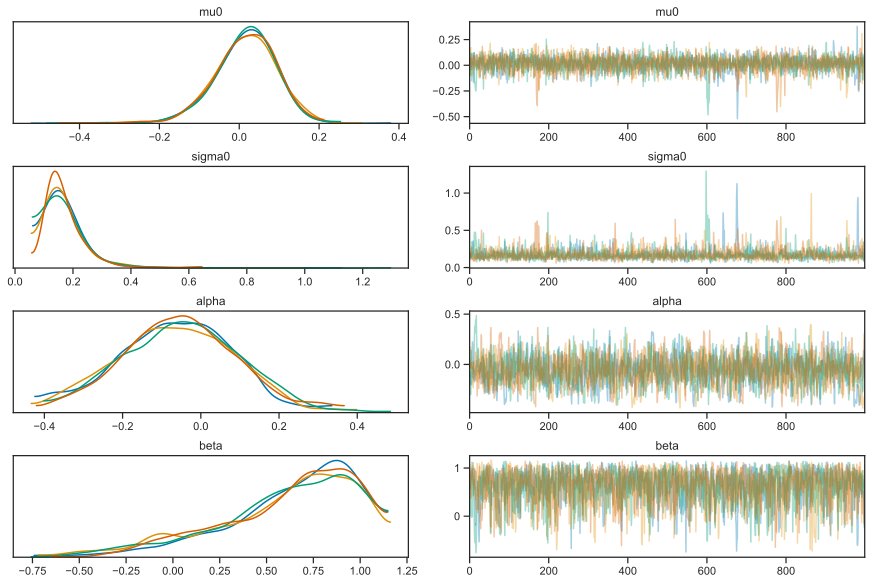

In [74]:
az.plot_trace(asamples, var_names=['mu0', 'sigma0', 'alpha', 'beta'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12775aba8>,
      dtype=object)

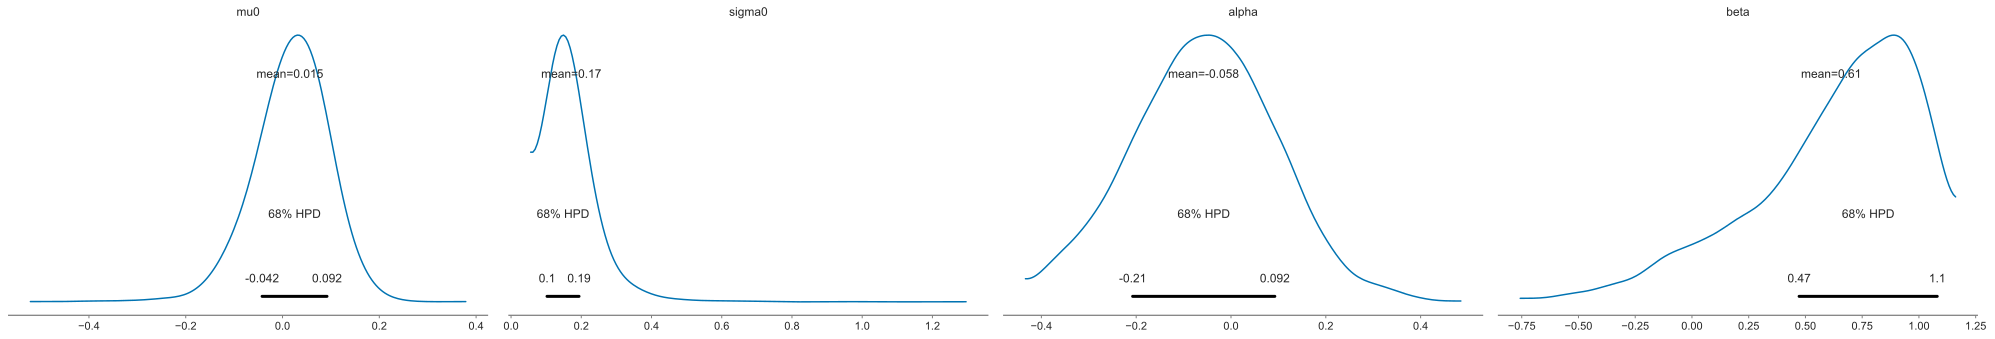

In [76]:
az.plot_posterior(asamples, var_names=['mu0', 'sigma0', 'alpha', 'beta'], credible_interval=0.68)

In [77]:
az.plot_pair(asamples, var_names=['mu0', 'sigma0', 'alpha', 'beta'], divergences=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127b880f0>,
      dtype=object)

In [80]:
CHIS, MS = meshgrid(linspace(-1, 1, 100), logspace(log10(5), log10(100), 100), indexing='ij')
PCHIS = zeros_like(CHIS)
for mu0, sigma0, alpha, beta in zip(*[asamples.posterior[k].values.flatten() for k in ['mu0', 'sigma0', 'alpha', 'beta']]):
    dist = ss.norm(loc=mu0+alpha*(MS/30-1), scale=sigma0*exp(beta*(MS/30-1)))
    PCHIS += dist.pdf(CHIS)/(dist.cdf(1) - dist.cdf(-1))
PCHIS /= len(asamples.posterior.mu0.values.flatten())

Text(0, 0.5, '$m_1$ ($M_\\odot$)')

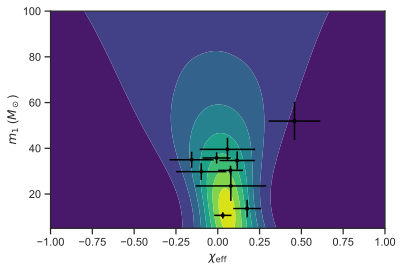

In [81]:
contourf(CHIS, MS, PCHIS, cmap='viridis', vmin=0)
for ce, m in zip(chiel, m1l):
    errorbar(mean(ce), mean(m), yerr=std(m), xerr=std(ce), fmt='.', color='k')
xlabel(r'$\chi_\mathrm{eff}$')
ylabel(r'$m_1$ ($M_\odot$)')

In [82]:
az.to_netcdf(asamples, 'pop-samples-running.nc')

'pop-samples-running.nc'